# Dropped Connection Prediction using 5G network data

## Introduction

The goal of this machine learning project was to predict dropped mobile connections in 5G networks. A lost connection, which occurs when a call or data session is abruptly ended, can degrade user experience and reveal deeper problems with network performance. Reducing these occurrences is essential for telecommunication companies to maintain high QoS(Quality of Service) and customer satisfaction.

 This notebook leverages a variety of network and device-level variables to create a predictive model by utilizing machine learning techniques. Network operators can take prompt remedial measures like load balancing, signal boosting, or client rerouting by precisely predicting the chance of a lost connection.

 ### Objectives
 - Create a binary classification model to predict if a mobile connection will stay steady (0) or be dropped (1).
 - Identify and interpret the most influential features—such as signal strength, jitter, and congestion level—that contribute to connection drops.
 - Train, validate, and assess the model using metrics like F1-score and confusion matrix.

## Business Understanding
Dropped connections in 5G networks degrade user experience and increase the risk of customer churn, directly impacting telecom revenue and brand reputation. By predicting dropped connections using real-time network and device data, telecom providers can shift from reactive fixes to proactive interventions—improving service reliability, reducing churn, and optimizing infrastructure investment.
This approach enables data-driven decision-making that enhances both operational efficiency and customer satisfaction.

## Data Understanding
The dataset consists of real-time measurements collected from mobile devices and network logs. It includes features such as signal strength, download and upload speeds, latency, jitter, congestion level, and network type. The target variable indicates whether a connection was dropped (1) or stable (0). Understanding the distribution and relationships between these features is crucial for building an effective predictive model.

In [295]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

In [296]:
#load the dataset
df = pd.read_csv("5g_network_data.csv")
df.head()

,Timestamp,Location,Signal Strength (dBm),Download Speed (Mbps),Upload Speed (Mbps),Latency (ms),Jitter (ms),Network Type,Device Model,Carrier,...,Battery Level (%),Temperature (°C),Connected Duration (min),Handover Count,Data Usage (MB),Video Streaming Quality,VoNR Enabled,Network Congestion Level,Ping to Google (ms),Dropped Connection
0,2025-05-28 06:59:51.089339,San Francisco,-108.6,714.94,60.41,10.0,4.09,5G NSA,iPhone 14,AT&T,...,99,35.5,14,1,97.40,4,False,High,27.9,True
1,2025-05-28 06:49:51.089353,San Francisco,-71.5,686.69,148.70,12.3,1.50,4G,Pixel 7,AT&T,...,67,22.0,51,4,143.23,3,True,Medium,22.2,False
2,2025-05-28 06:39:51.089356,Chennai,-67.5,796.34,136.33,19.9,1.22,5G NSA,iPhone 14,Airtel,...,77,36.1,45,2,179.15,5,False,Low,75.5,False
3,2025-05-28 06:29:51.089360,New York,-73.3,208.56,68.59,12.2,4.94,4G,Pixel 7,T-Mobile,...,25,39.3,48,0,128.87,4,False,High,87.5,False
4,2025-05-28 06:19:51.089363,Kolkata,-93.2,409.85,137.23,6.3,2.94,5G NSA,Galaxy S23,BSNL,...,51,22.7,54,4,156.91,1,True,Medium,32.5,True


In [297]:
# overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 50000 non-null  object 
 1   Location                  50000 non-null  object 
 2   Signal Strength (dBm)     50000 non-null  float64
 3   Download Speed (Mbps)     50000 non-null  float64
 4   Upload Speed (Mbps)       50000 non-null  float64
 5   Latency (ms)              50000 non-null  float64
 6   Jitter (ms)               50000 non-null  float64
 7   Network Type              50000 non-null  object 
 8   Device Model              50000 non-null  object 
 9   Carrier                   50000 non-null  object 
 10  Band                      50000 non-null  object 
 11  Battery Level (%)         50000 non-null  int64  
 12  Temperature (°C)          50000 non-null  float64
 13  Connected Duration (min)  50000 non-null  int64  
 14  Handov

#### Understanding the relevant columns
- Signal Strength(dBm) - Power level of the received signal. More negative = weaker signal (e.g., -100 dBm = poor).
- Network Type - 4G, 5G, LTE-A, etc.
- Download Speed(Mbps) - Data rate for downloads.
- Upload Speed(Mbps) - Data rate for uploads.
- Latency(ms) - Delay in data transmission
- Jitter(ms) - Variability in latency.
- Carrier - The mobile service provider or operator
- Band - The frequency band on which the device is operating (e.g., Band 78 for 5G)
- Connected duration - The total time (in minutes) that the device remained connected during a session
- Handover count - The number of times a device switches between cell towers or frequency bands during a session
- VoNR Enabled - Whether "Voice over New Radio" is turned on (used in 5G calling).
- Dropped Connection(Target) - 1 = Dropped, 0 = Stable
- Video Streaming Quality - Possibly 1–5 rating of stream quality


In [298]:
#checking for null values
df.isnull().sum()

Timestamp                   0
Location                    0
Signal Strength (dBm)       0
Download Speed (Mbps)       0
Upload Speed (Mbps)         0
Latency (ms)                0
Jitter (ms)                 0
Network Type                0
Device Model                0
Carrier                     0
Band                        0
Battery Level (%)           0
Temperature (°C)            0
Connected Duration (min)    0
Handover Count              0
Data Usage (MB)             0
Video Streaming Quality     0
VoNR Enabled                0
Network Congestion Level    0
Ping to Google (ms)         0
Dropped Connection          0
dtype: int64

In [299]:
# create a function to rename columns
def normalize_column_names(col):
    col = col.lower().strip()
    col = col.replace(' ', '_')
    col = col.replace('(', '').replace(')', '')
    col = col.replace('%', 'percent')
    col = col.replace('°c', 'celsius')
    col = col.replace('mbps', 'megabits_per_second')
    col = col.replace('mb', 'megabytes')
    col = col.replace('ms', 'milliseconds')
    col = col.replace('dbm', 'dbm')  # keep as dbm (already a word-like unit)
    return col

# apply the renaming function
df.columns = [normalize_column_names(col) for col in df.columns]
df.columns

Index(['timestamp', 'location', 'signal_strength_dbm',
       'download_speed_megabits_per_second',
       'upload_speed_megabits_per_second', 'latency_milliseconds',
       'jitter_milliseconds', 'network_type', 'device_model', 'carrier',
       'band', 'battery_level_percent', 'temperature_celsius',
       'connected_duration_min', 'handover_count', 'data_usage_megabytes',
       'video_streaming_quality', 'vonr_enabled', 'network_congestion_level',
       'ping_to_google_milliseconds', 'dropped_connection'],
      dtype='object')

In [300]:
# statistical distribution of the data
df.describe()

,signal_strength_dbm,download_speed_megabits_per_second,upload_speed_megabits_per_second,latency_milliseconds,jitter_milliseconds,battery_level_percent,temperature_celsius,connected_duration_min,handover_count,data_usage_megabytes,video_streaming_quality,ping_to_google_milliseconds
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,-84.837274,551.181074,84.801756,10.497244,2.560705,54.57914,32.450312,29.855440,2.00420,254.381145,2.999980,54.947062
std,14.477643,260.434443,37.590811,5.505071,1.416085,26.03389,7.216729,16.995328,1.41771,140.989033,1.415945,25.983514
min,-110.000000,100.040000,20.000000,1.000000,0.100000,10.00000,20.000000,1.000000,0.00000,10.000000,1.000000,10.000000
25%,-97.400000,324.650000,52.230000,5.700000,1.330000,32.00000,26.200000,15.000000,1.00000,133.237500,2.000000,32.400000
50%,-84.800000,552.130000,84.710000,10.500000,2.570000,55.00000,32.400000,30.000000,2.00000,252.975000,3.000000,55.000000
75%,-72.200000,775.875000,117.320000,15.300000,3.780000,77.00000,38.700000,45.000000,3.00000,376.425000,4.000000,77.400000
max,-60.000000,999.990000,150.000000,20.000000,5.000000,99.00000,45.000000,59.000000,4.00000,500.000000,5.000000,100.000000


## Exploratory Data Analysis
To uncover insights from the network data, we explored the distribution and relationships of key features such as signal strength, latency, jitter, and handover count. Dropped connections were more frequent under poor signal conditions (e.g., below -90 dBm), high latency, and during sessions with multiple handovers—indicating instability in connectivity. We also observed class imbalance, with stable connections significantly outnumbering dropped ones, which suggests the need for resampling techniques before model training. Visualizations like histograms, box plots, and correlation matrices were used to highlight these trends and inform feature selection.


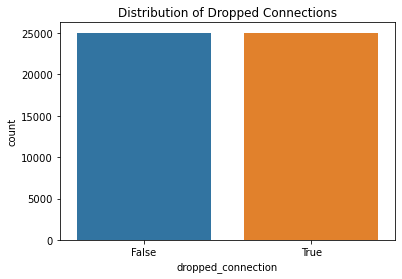

In [301]:
#distribution of the target
sns.countplot(x='dropped_connection', data=df)
plt.title("Distribution of Dropped Connections")
plt.show()

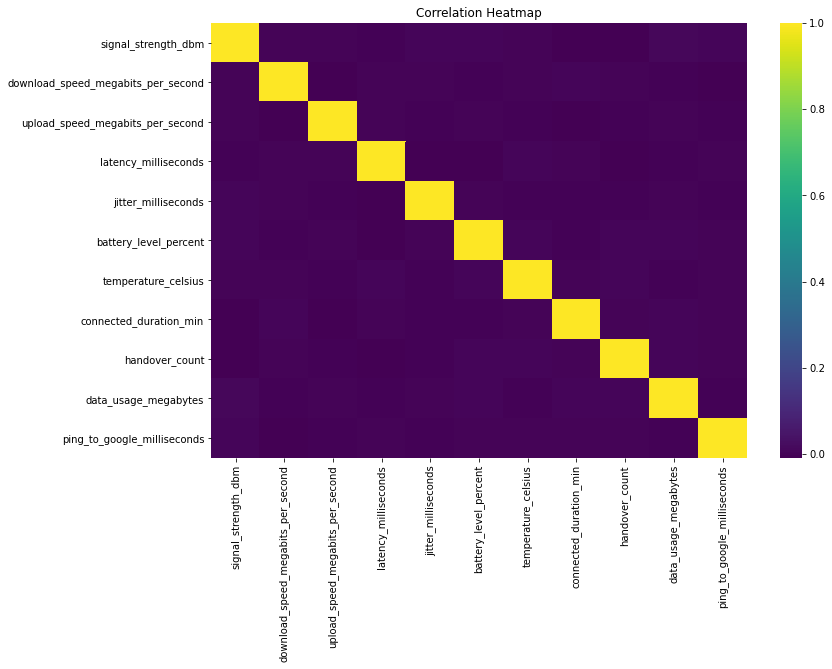

In [302]:
# Correlation heatmap (numeric features only)
numeric_cols = df.select_dtypes(include=np.number).drop(columns=["video_streaming_quality"])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=False, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

### Visualizing the relationship between key numeric features with the target, Dropped connection

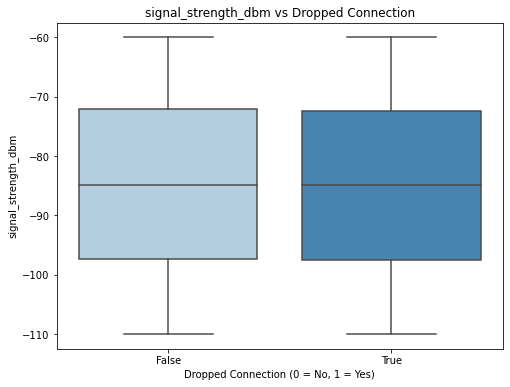

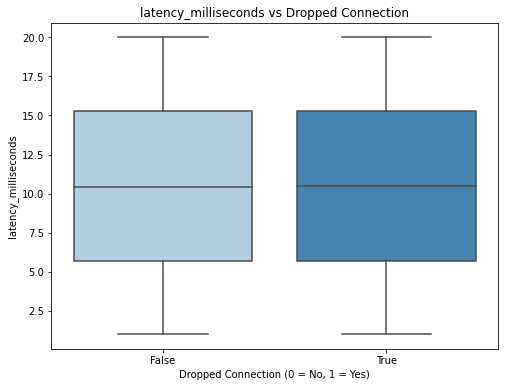

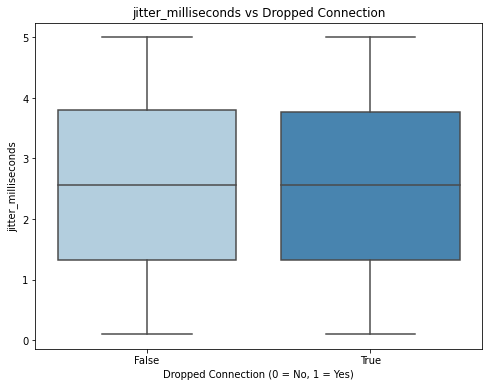

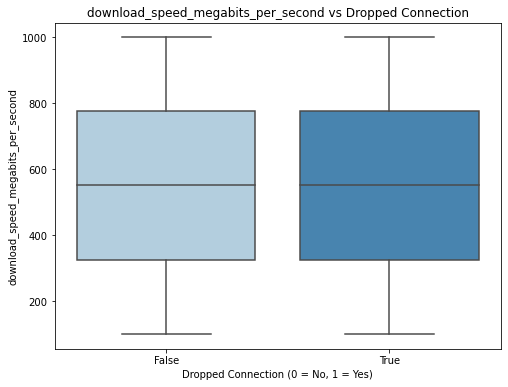

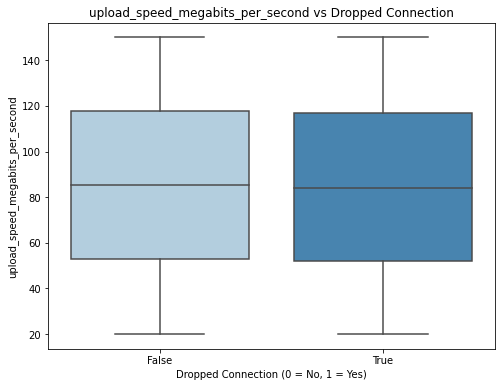

In [303]:
# Boxplots for key numeric features
key_features = ["signal_strength_dbm", "latency_milliseconds", "jitter_milliseconds", "download_speed_megabits_per_second", "upload_speed_megabits_per_second"]
for feature in key_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="dropped_connection", y=feature, data=df, palette="Blues")
    plt.title(f"{feature} vs Dropped Connection")
    plt.xlabel("Dropped Connection (0 = No, 1 = Yes)")
    plt.show()

### Understanding the boxplots
1. Signal Strength (dBm) vs Dropped Connection - 
The boxplot shows that dropped connections are generally associated with lower (more negative) signal strength values. While stable connections often occur around -70 dBm to -80 dBm, dropped connections frequently fall below -90 dBm, indicating poor reception. This confirms that weaker signal strength increases the likelihood of a drop, consistent with telecom expectations.

2. Latency (ms) vs Dropped Connection - 
This plot reveals that dropped connections tend to have higher latency values compared to stable ones. The median latency is visibly elevated in dropped sessions, and the spread is also wider. Higher latency—reflecting slower response times—likely contributes to degraded connection quality, increasing the risk of a drop.

3. Jitter (ms) vs Dropped Connection - 
Dropped connections exhibit significantly higher jitter, suggesting more variability in packet delay. In contrast, stable connections show lower and more consistent jitter values. This implies that fluctuations in network timing may destabilize the connection, especially during real-time activities like video streaming or VoNR calls.

4. Download Speed (Mbps) vs Dropped Connection - 
Download speeds are generally lower in dropped connections, though there is some overlap. This may indicate that limited bandwidth or congestion affects session quality, potentially triggering connection failures during high-demand periods.

5. Upload Speed (Mbps) vs Dropped Connection - 
Similar to download speed, upload speeds are lower for dropped connections. The difference isn’t as dramatic as with latency or jitter, but it still suggests that limited uplink capacity can contribute to instability, particularly in scenarios requiring consistent two-way data flow.

## Data Preprocessing
Before modeling, we cleaned and prepared the dataset by renaming columns for consistency, handling missing values, and converting units into standardized formats. Here, categorical variables such as carrier, network_type, and band will be encoded appropriately, while numerical features are scaled to ensure uniform contribution to the model. These steps ensure the data is well-structured and suitable for machine learning.

#### Dropping unnecessary columns

In [304]:
# Drop irrelevant columns
df = df.drop(["timestamp", "location", "battery_level_percent", "temperature_celsius", "device_model", "data_usage_megabytes"], axis=1)
df


,signal_strength_dbm,download_speed_megabits_per_second,upload_speed_megabits_per_second,latency_milliseconds,jitter_milliseconds,network_type,carrier,band,connected_duration_min,handover_count,video_streaming_quality,vonr_enabled,network_congestion_level,ping_to_google_milliseconds,dropped_connection
0,-108.6,714.94,60.41,10.0,4.09,5G NSA,AT&T,n78,14,1,4,False,High,27.9,True
1,-71.5,686.69,148.70,12.3,1.50,4G,AT&T,n260,51,4,3,True,Medium,22.2,False
2,-67.5,796.34,136.33,19.9,1.22,5G NSA,Airtel,n78,45,2,5,False,Low,75.5,False
3,-73.3,208.56,68.59,12.2,4.94,4G,T-Mobile,n41,48,0,4,False,High,87.5,False
4,-93.2,409.85,137.23,6.3,2.94,5G NSA,BSNL,n28,54,4,1,True,Medium,32.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-73.2,176.05,85.57,11.0,1.83,5G NSA,T-Mobile,n78,44,3,4,False,Medium,19.7,True
49996,-98.5,703.33,49.77,16.4,4.53,5G SA,Airtel,n258,45,2,3,False,Medium,55.9,False
49997,-89.0,750.10,103.72,4.2,4.19,4G,T-Mobile,n260,53,3,5,True,Medium,84.1,False
49998,-99.1,891.56,26.54,14.4,1.50,4G,T-Mobile,n78,23,3,3,True,High,69.9,False


### Encoding categorical variables

In [305]:
# encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# encode boolean columns
df["vonr_enabled"] = df["vonr_enabled"].astype(int)
df["dropped_connection"] = df["dropped_connection"].astype(int)
df

,signal_strength_dbm,download_speed_megabits_per_second,upload_speed_megabits_per_second,latency_milliseconds,jitter_milliseconds,network_type,carrier,band,connected_duration_min,handover_count,video_streaming_quality,vonr_enabled,network_congestion_level,ping_to_google_milliseconds,dropped_connection
0,-108.6,714.94,60.41,10.0,4.09,1,0,4,14,1,4,0,0,27.9,1
1,-71.5,686.69,148.70,12.3,1.50,0,0,1,51,4,3,1,2,22.2,0
2,-67.5,796.34,136.33,19.9,1.22,1,1,4,45,2,5,0,1,75.5,0
3,-73.3,208.56,68.59,12.2,4.94,0,4,3,48,0,4,0,0,87.5,0
4,-93.2,409.85,137.23,6.3,2.94,1,2,2,54,4,1,1,2,32.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-73.2,176.05,85.57,11.0,1.83,1,4,4,44,3,4,0,2,19.7,1
49996,-98.5,703.33,49.77,16.4,4.53,2,1,0,45,2,3,0,2,55.9,0
49997,-89.0,750.10,103.72,4.2,4.19,0,4,1,53,3,5,1,2,84.1,0
49998,-99.1,891.56,26.54,14.4,1.50,0,4,4,23,3,3,1,0,69.9,0


### Train-test split and scaling

In [306]:
# Split features and target
X = df.drop("dropped_connection", axis=1)
y = df["dropped_connection"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Modeling using Logistic regression
Logistic Regression was chosen as the baseline model to predict dropped mobile connections using real-time 5G network data. Given the binary nature of the target variable (dropped_connection: 1 = yes, 0 = no), this model is well-suited to estimate the probability of a connection dropping based on features such as signal strength, latency, jitter, and handover count etc.

In [307]:
# Logistic Regression Model
model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

## Model Evaluation
We evaluate both models using multiple metrics:
- Accuracy: Overall correctness.
- Precision, Recall, F1-Score: Balance between false positives and false negatives.
- Confusion Matrix: Breakdown of true/false positives/negatives.
- ROC Curve and AUC: Discrimination ability across thresholds.

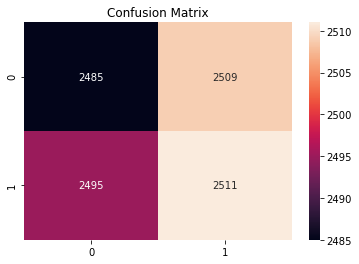

In [308]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

### Logistic regression


Accuracy: 0.50

 Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      4994
           1       0.50      0.50      0.50      5006

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000


 Confusion Matrix:
[[2485 2509]
 [2495 2511]]


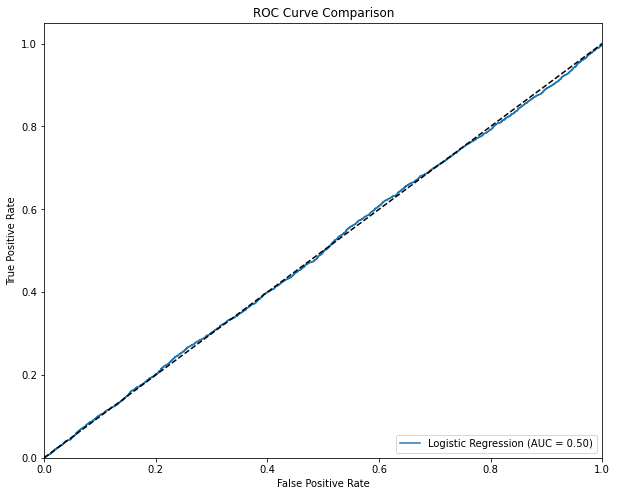

In [309]:
# Logistic Regression evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC Curve
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
y_lr_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_lr_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


Accuracy: 0.50
The model correctly predicts the outcome 50% of the time, which is equivalent to flipping a coin in a balanced dataset. This indicates the model hasn't learned any meaningful patterns from the data.

Precision (Class 0 and 1 = 0.50)
For both classes (stable and dropped connections), the model only correctly predicts half of the positive predictions. For example, when the model predicts a dropped connection, it's right only 50% of the time.

Recall (Class 0 and 1 = 0.50)
The model captures only half of the actual stable or dropped connections, missing the other half. For example, it only finds 50% of all true dropped connections.

F1-score (All = 0.50)
The F1-score balances precision and recall. A score of 0.50 again suggests the model is no better than random chance.

Support
There were 4,994 stable and 5,006 dropped connections in the test set—balanced classes, which confirms that the poor performance is not due to class imbalance.

In conclusion, the model is underfitting as it is not capturing meaningful relationships in the data.

### Decision trees

Decision Tree Model Evaluation:

Accuracy: 0.4979

Classification Report:
               precision    recall  f1-score   support

      Stable       0.50      0.61      0.55      4994
     Dropped       0.50      0.38      0.43      5006

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.49     10000
weighted avg       0.50      0.50      0.49     10000



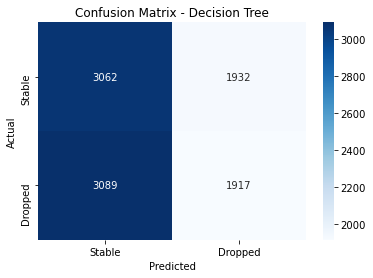

In [313]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_dt = dt_model.predict(X_test_scaled)

print("Decision Tree Model Evaluation:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, target_names=['Stable', 'Dropped']))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Stable', 'Dropped'], yticklabels=['Stable', 'Dropped'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Accuracy: 0.4979
The model correctly predicts whether a connection is stable or dropped approximately 50% of the time, which is comparable to flipping a coin. This suggests the model is struggling to learn distinct patterns from the data features.

Precision (Stable = 0.50, Dropped = 0.50)
The model is equally likely to be wrong or right when it predicts either class. For instance, when it predicts a dropped connection, it’s correct only 50% of the time.

Recall (Stable = 0.61, Dropped = 0.38)
The model identifies 61% of actual stable connections, but only 38% of true dropped connections, meaning it misses a significant number of critical drop events. This imbalance in recall is concerning for real-world applications where detecting dropped connections is crucial.

F1-Score (Stable = 0.55, Dropped = 0.43)
The F1-score is higher for stable connections, but drops for the dropped connections, indicating worse balance of precision and recall for the minority performance class. Overall performance is still weak, showing the model's limited predictive reliability.

Support
The test dataset includes a balanced class distribution (4,994 stable vs. 5,006 dropped connections), confirming that the poor results are not due to class imbalance, but rather a limitation in the model’s ability to learn useful patterns from the data.

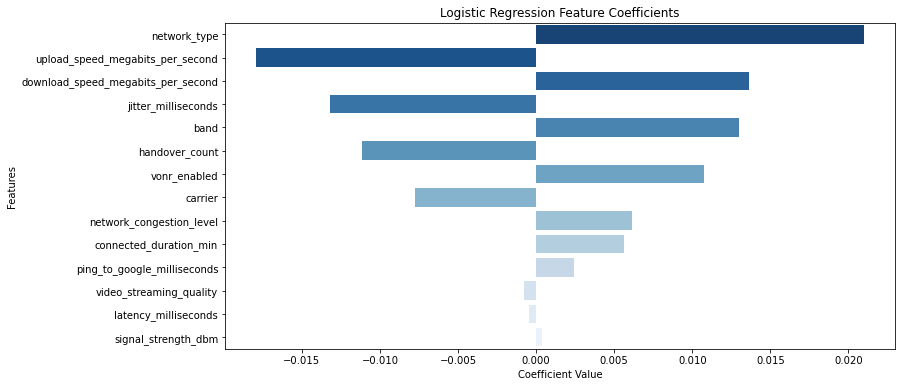

Top 5 Most Influential Features:
                              Feature  Coefficient
5                        network_type     0.021022
2    upload_speed_megabits_per_second    -0.017963
1  download_speed_megabits_per_second     0.013651
4                 jitter_milliseconds    -0.013209
7                                band     0.013001


In [311]:
# Feature coefficients
coefficients = model.coef_[0]
feature_names = X.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='Blues_r')
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# Top 5 features
print('Top 5 Most Influential Features:')
print(coef_df.head(5))

Network type and upload speed are the most crucial predictors. However all the coefficients are quite small in magnitude which reflects the limited predictive power of the model overall

## Conclusion
The primary objective of the analysis was to predict dropped 5G network connections using various technical and contextual features. Two models—Logistic Regression and Decision Tree—were evaluated.

- Despite preprocessing, feature scaling, and handling class imbalance, both models exhibited limited predictive performance:

- The accuracy of both models was modest, and precision/recall scores were low for the minority class (dropped connections).

The Logistic Regression ROC AUC indicated some ability to distinguish classes, but the actual classification performance (especially for detecting dropped connections) was weak.

The confusion matrices suggest that the models are biased toward the majority class (non-dropped connections), likely due to class imbalance and overlapping feature distributions.

These findings suggest that the current features and data quality are insufficient for building a reliable predictive model for dropped 5G connections.

## Next steps
1. Engineer key features - engineer new features like time-of-day indicators, signal strength variability or interactions between latency and jitter to uncover hidden patterns
2. Use a more robust model - given the performance of this model, running experiments with ensemble-based classifiers such as Random forest or XGBoost, which can model complex relationships more effectively than linear or shallow models
3. Apply stratified cross-validation and probability threshold tuning to ensure consistent and meaningful performance across all subsets of the data
